## Setup environment

In [4]:
from simulators.grid_world.grid_world import Maze
from simulators.grid_world.metrics import compute_bad_steps

grid_type = "simple"

feature_type = "one_hot"
dimensions = 124
sigma = None

# feature_type = "simularity"
# dimensions = 100
# sigma = 0.25

n_tries_for_std = 10

env = Maze(grid_type, feature_type, dimensions=dimensions, sigma=sigma)

### Change reward to granular setting

In [5]:
from simulators.grid_world.grid_world import set_granular_reward, set_normilized_reward, divide_reward_by

env = set_granular_reward(env)
env = set_normilized_reward(env)
env = divide_reward_by(env, 10)

## NAC

#### Check when a lot of samples are given

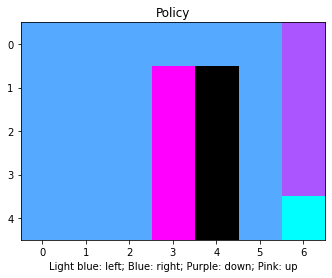

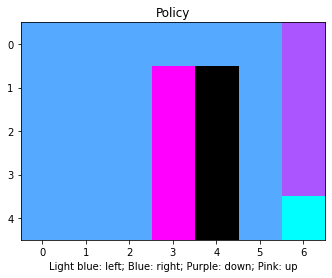

Number of bad policy: 0


In [47]:
# from algorithms.NAC.nac import nac

entropy_weight = 0.1
n_expert_samples = 150
n_expert_iterations = 50
n_rl_iterations = 0
batch_size = 10
update_target_frequency = 10
show_args = {"show_policy":True, "show_value_function": False, "show_statistics": False, "display_frequency": (n_expert_iterations + n_rl_iterations) / 2}


NAC_Q, NAC_policy = nac(
    env,
    entropy_weight, 
    n_expert_samples, 
    n_expert_iterations, 
    n_rl_iterations, 
    batch_size,
    update_target_frequency,
    **show_args,
)
print("Number of bad policy:", compute_bad_steps(env, NAC_policy))

#### Experiment the real algorithm

In [115]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical


class SmallNAC(nn.Module):
    def __init__(self, env, entropy_weight):
        super(SmallNAC, self).__init__()
        self.env = env
        self.entropy_weight = entropy_weight

        self.net = nn.Sequential(
            nn.Linear(124, 1), nn.Sigmoid()
        )
        
        self.net[0].weight.data = 0 * torch.ones(self.net[0].weight.data.size())
        self.net[0].bias.data = -3.4 * torch.ones(self.net[0].bias.data.size())

    def Q(self, state, action):
        return 3 * self.net(torch.tensor(self.env.get_feature(state, action), dtype=torch.float32))

    def V(self, state):
        v_value = 0

        for action in self.env._actions:
            v_value += torch.exp(self.Q(state, action) / self.entropy_weight)

        return self.entropy_weight * torch.log(v_value)

    def policy(self, state):
        return self.pi_distribution(state).sample()

    def pi_distribution(self, state):
        pi_actions = torch.zeros((self.env.Na))

        for action in self.env._actions:
            pi_actions[action] = torch.exp((self.Q(state, action) - self.V(state)) / self.entropy_weight)

        return Categorical(probs=pi_actions)

    def copy_to(self, target_model):
        target_model.load_state_dict(self.state_dict())

In [138]:
def get_q_learning_loss(batch, model, target_model):
    q_learning_loss = 0

    for (state, action, reward, next_state) in batch:
        # Actor's loss
        q_require_grad = model.Q(state, action)

        with torch.no_grad():
            best_q = - float("inf")
            for other_action in env._actions:
                q_other_action = target_model.Q(state, other_action)

                if q_other_action > best_q:
                    best_q = q_other_action
        
        q_learning_loss += (q_require_grad - (reward + model.env.gamma * best_q))**2

    return q_learning_loss
    

def get_actor_critic_loss(batch, model, target_model):
    actor_loss = 0
    critic_loss = 0

    for (state, action, reward, next_state) in batch:
        # Actor's loss
        q_require_grad = model.Q(state, action)
        v_require_grad = model.V(state)

        with torch.no_grad():
            v_target = target_model.V(next_state)
            entropy = model.pi_distribution(state).entropy()
        
        actor_loss += (q_require_grad - v_require_grad) * (q_require_grad.detach() - (reward + model.env.gamma * v_target))

        # Critic loss
        critic_loss += v_require_grad * (v_require_grad.detach() - (reward + model.env.gamma * v_target + model.entropy_weight * entropy))

    return actor_loss + critic_loss

In [139]:
import matplotlib.pyplot as plt 

class ReplayBuffer:
    def __init__(self, env, n_expert_samples, expert_policy, batch_size):
        self.env = env

        self.buffer_expert = []
        self.buffer_rl = []

        if n_expert_samples > 0:  # i.e with Demonstration
            self.collect_expert_samples(n_expert_samples, expert_policy)

        self.batch_size = batch_size
        self.rl_state = self.env.initial_state_distribution
        self.terminal = False

    def collect_expert_samples(self, n_samples, policy):
        for idx_sample in range(n_samples):
            state = np.random.choice(self.env._states) if idx_sample != 0 else self.env.initial_state_distribution
            self.env.state = state
            
            action = policy[state]

            next_state, reward, _, _ = self.env.step(action)

            self.buffer_expert.append((state, action, reward, next_state))

    def collect_rl_sample(self, model):
        if self.terminal:
            self.rl_state = np.random.choice(self.env._states)
        self.env.state = self.rl_state

        action = model.policy(self.env.state).detach().numpy()

        next_state, reward, self.terminal, _ = self.env.step(action)

        self.buffer_rl.append((self.rl_state, action, reward, next_state))
        self.rl_state = next_state
    
    def get_batch(self, from_expert=True):
        if from_expert:
            return [self.buffer_expert[np.random.choice(range(len(self.buffer_expert)))] for _ in range(self.batch_size)]
        else:
            return [self.buffer_rl[np.random.choice(range(len(self.buffer_rl)))] for _ in range(self.batch_size)]

    def display_statistics(self, from_expert):
        number_occurences = np.zeros(self.env.S)

        if from_expert:
            for (state, _, _, _) in self.buffer_expert:
                number_occurences[state] += 1
        else:
            for (state, _, _, _) in self.buffer_rl:
                number_occurences[state] += 1       

        img = self.env.get_layout_img(number_occurences)
        plt.figure()
        plt.title("Statistics on occurences")
        plt.imshow(img)
        plt.show()

In [140]:
import numpy as np


def nac(env, loss_name, entropy_weight, n_expert_samples, n_expert_iterations, n_rl_iterations, batch_size, update_target_frequency, show_policy=False, show_value_function=False, show_statistics=False, display_frequency=1):
    # from algorithms.NAC.replay_buffer import ReplayBuffer
    # from algorithms.NAC.model import SmallNAC

    if n_expert_samples > 0:
        from algorithms.VI_dynamic_programming import value_iteration

        _, expert_policy = value_iteration(env.P, env.R, env.gamma)
    else:
        expert_policy = None
    
    replay_buffer = ReplayBuffer(
        env,
        n_expert_samples,
        expert_policy,
        batch_size,
    )
    model = SmallNAC(env, entropy_weight)
    target_model = SmallNAC(env, entropy_weight)
    model.copy_to(target_model)

    if loss_name == "q_learning":
        get_loss = get_q_learning_loss
    elif loss_name == "actor_critic":
        get_loss = get_actor_critic_loss

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    for iteration in range(1, n_expert_iterations + n_rl_iterations + 1):
        from_expert = True if iteration <= n_expert_iterations else False

        if iteration > n_expert_iterations:
            optimizer.param_groups[0]['lr'] = 1e-3

        if not from_expert:
            replay_buffer.collect_rl_sample(model)

        batch = replay_buffer.get_batch(from_expert=from_expert)

        if show_statistics and iteration % display_frequency == 0:
            replay_buffer.display_statistics(from_expert)

        loss = get_loss(batch, model, target_model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if show_value_function and iteration % display_frequency == 0:
            value_function = np.zeros((env.Ns))

            for state in env._states:
                value_function[state] = model.V(state)
            env.display_value_function(value_function, from_value=True)
        if (show_policy and iteration % display_frequency == 0) or iteration == n_expert_iterations + 1:
            if iteration == n_expert_iterations + 1:
                print("End expert iterations")
            policy = np.zeros((env.Ns))

            for state in env._states:
                policy[state] = np.argmax(model.pi_distribution(state).probs.detach().numpy())
            env.display_policy(policy, from_pi=True)

        if iteration % update_target_frequency == 0:
            model.copy_to(target_model)

    policy = np.zeros((env.Ns), dtype=int)

    for state in env._states:
        policy[state] = np.argmax(model.pi_distribution(state).probs.detach().numpy())
        
    return model, policy

  0%|          | 0/1 [00:00<?, ?it/s]

End expert iterations


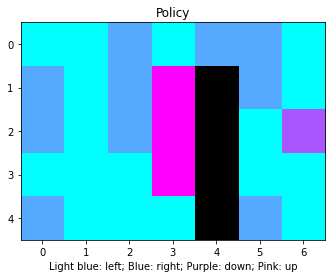

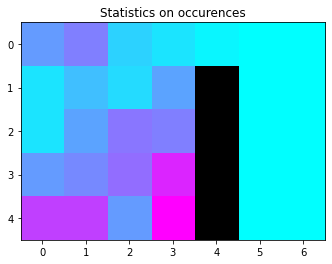

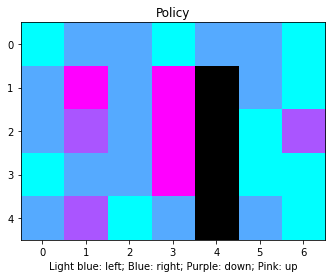

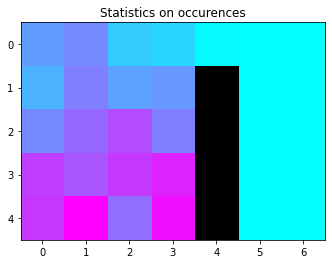

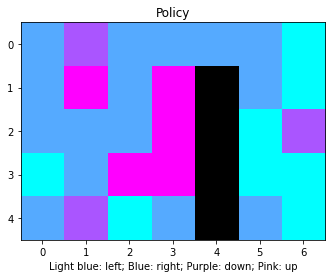

100%|██████████| 1/1 [00:24<00:00, 24.57s/it]

Bad policy: 10
Bad policies: 10.0 +- 0.0
Average time 24.569 +- 0.0


In [141]:
import time 
import numpy as np

from tqdm import tqdm 
# from algorithms.NAC.nac import nac

loss_name = "actor_critic"
entropy_weight = 0.1
n_expert_samples = 20
n_expert_iterations = 10
n_rl_iterations = 500
batch_size = 10
update_target_frequency = 20
show_args = {"show_policy":True, "show_value_function": False, "show_statistics": True, "display_frequency": (n_expert_iterations + n_rl_iterations) / 2}

time_algorithm = []
bad_policies = []

for n_try in tqdm(range(1)):
    time_begin = time.time()
    NAC_Q, NAC_policy = nac(
        env,
        loss_name,
        entropy_weight, 
        n_expert_samples, 
        n_expert_iterations, 
        n_rl_iterations, 
        batch_size,
        update_target_frequency,
        **show_args,
    )
    time_algorithm.append(time.time() - time_begin)
    bad_policy = compute_bad_steps(env, NAC_policy)
    print(f"Bad policy: {bad_policy}")
    bad_policies.append(bad_policy)

print(f"Bad policies: {np.around(np.mean(bad_policies), 3)} +- {np.around(np.std(bad_policies), 3)}")
print(f"Average time {np.around(np.mean(time_algorithm), 3)} +- {np.around(np.std(time_algorithm), 3)}")